Issues:
- the cameo fasta files i donwloaded included some dna files somehow. Use https://github.com/aqlaboratory/openfold/blob/main/scripts/download_cameo.py 
- the hhmfiles/hmmstats sometimes have different names? or more or less proteins. Basically double check hmmfile and the generated pdbs from the runs
- do NOT include relaxed proteins. Use unrelaxed structures only.
- Not all proteins were plotted. Many proteins have seqs > 160 but are not plotted? reset how dictionaries are made and plotted.

To Do:
- Make markdown notes to keep track of my experiments and plots and what I find.
- clear/move run saves and clean work area
- reorganize openfold-mt and 'res/' in general
    - put the plotting ipynb files with the data i'm interested in, perhaps
- download correct cameo fasta data
- run with/without s=s*0
- compute hhmstats
- rebuild scripts for generating dictionaries and plots. Something goes wrong when hmmstats and downloaded-pdbs do not agree.
    


*Dont include relaxation- generally stick to unrelaxed strucs.



In [17]:
import scipy

In [18]:
import os
def tmscore(target, modified):
    tmscore = -1
    os.system(f"./tmscore/TMscore {target} {modified} >> tmscore_temp_output")
    with open("tmscore_temp_output") as f:
        for line in f:
            if line.startswith("TM-score"):
                tmscore = float(line.split('=')[1].strip().split(' ')[0])
    os.system("rm tmscore_temp_output")
    return tmscore

In [19]:
os.getcwd()

'/Users/trumbull/res/openfold-mt'

In [20]:
# 7lew_B failed s=s*0 'particle coordinate is a nan' error thrown
# NOTE: 7s13, 7nx0, and 7eqx have multiple seq in the vdata. Possibly ran wrong seq with wrong aignmeent? 
# idk what happened. skip these protiens
# !! ACTUALLY: the other conf runs _L,_E,_C respectively are not in validationrunsdict. therefore 
# i never ran those versions. I should still check the sequences at the top of the alignments file match the sequences 
# in the fasta file i ran it with.. Run check in next cell.

import os
validationrunsdict = {}
validationrunsdict_relaxed = {}
validationrunsdict_unrelax = {}
modified_dir = 'taccruns/predictions-s_zeroed/'
main_dir = 'taccruns/predictions-normal/'
for run_pdb in os.listdir(main_dir):
    if run_pdb[-1] == "b":
        #validationrunsdict[run_pdb[0:6]+'_'+run_pdb[19:26]] = [tmscore(main_dir + run_pdb, modified_dir + run_pdb),]
        #if run_pdb[19:26] == 'relaxed' and run_pdb[0:4]:
        #    validationrunsdict_relaxed[run_pdb[0:6]] = tmscore(main_dir + run_pdb, modified_dir + run_pdb)
        if run_pdb[19:26] == 'unrelax':
            validationrunsdict_unrelax[run_pdb[0:6]] = tmscore(main_dir + run_pdb, modified_dir + run_pdb)



In [21]:
# CHECK RUN!!!

# Check that the sequence at the top of each uniref... alignment file is the same sequence in the fasta file that was run.


# Is there a relationship between the pair rep and resulting tm score? maybe I could count number of times certain residues pop up?


# do analysis again for relaxed / unrelaxed


# is there a relationship to physical width?



In [22]:
###
### BROKEN
###

import numpy as np
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
def get_max_atom_distance(protein):
    max_dist = 0
    list_atom_locs = []
    pth = "taccruns/predictions-normal/" + protein + "_model_1_ptm_relaxed.pdb"
    with open(pth) as p:
        content = p.readlines()
    for line in content:
        if line.startswith("ATOM"):
            list_atom_locs.append([float(line.split()[6]),float(line.split()[7]),float(line.split()[8])])
    points = np.array(list_atom_locs)
    hull = ConvexHull(points)
    hullpoints = points[hull.vertices,:]
    hdist = cdist(hullpoints, hullpoints, metric='euclidean')
    bestpair = np.unravel_index(hdist.argmax(), hdist.shape)
    print([hullpoints[bestpair[0]],hullpoints[bestpair[1]]])
    
    return max_dist

#print(get_max_atom_distance("6tf4_A"))

In [37]:
def get_amino_acid_len(dir, protien):
    with open(dir + protien + '.fasta') as f:
        fastafile = f.readlines()
    return(len(fastafile[1]))
get_amino_acid_len('fasta_dir/','7rdt_A')

251

In [24]:
hmmfile_details = ["nseq","eff_nseq","M","relent","info","prelE","compKL"]
def get_hmmfile_dict(Neff_file_path):
    dict = {}
    with open(Neff_file_path) as f:
        lines = f.readlines()
    for line in lines:
        dict[line[0:6]] = {}
        for i,detail in enumerate(hmmfile_details):
            dict[line[0:6]][detail] = float(line.split()[i+4])
        #print(line[0:6], line.split())
    return dict
hmmfile_dict = get_hmmfile_dict('taccruns/predictions/validata_from_hmmstat.txt')

# add MSV to hmmfile
with open('taccruns/predictions/MSV_from_hmmfile.txt') as f:
    lines = f.readlines()
for line in lines:
    for i,detail in enumerate(['MSV1','MSV2']):
        #print(line)
        hmmfile_dict[line[0:6]][detail] = float(line.split()[i+4])
    hmmfile_dict[line[0:6]]['MSV_delta'] = abs(float(line.split()[4]) - float(line.split()[5]))

# add FORWARD
with open('taccruns/predictions/FORWARD_from_hmmfile.txt') as f:
    lines = f.readlines()
for line in lines:
    for i,detail in enumerate(['FORWARD1','FORWARD2']):
        hmmfile_dict[line[0:6]][detail] = float(line.split()[i+4])
    hmmfile_dict[line[0:6]]['FORWARD_delta'] = abs(float(line.split()[4]) - float(line.split()[5]))


# add VITERBI
with open('taccruns/predictions/VITERBI_from_hmmfile.txt') as f:
    lines = f.readlines()
for line in lines:
    for i,detail in enumerate(['VITERBI1','VITERBI2']):
        hmmfile_dict[line[0:6]][detail] = float(line.split()[i+4])
    hmmfile_dict[line[0:6]]['VITERBI_delta'] = abs(float(line.split()[4]) - float(line.split()[5]))
    



# add amino_acid_len to hmmfile_dict
proteins_to_remove = []
for protein in hmmfile_dict:
    try:
        hmmfile_dict[protein]['amino_acid_len'] = get_amino_acid_len('fasta_dir/',protein)
    except:
        print(protein, " will be removed. It is present in the alignments file, but was not a fasta file that was run.")
        proteins_to_remove.append(protein)
for rm in proteins_to_remove:
    del hmmfile_dict[rm]

### BROKEN
# add max atom distance to hmmfile_dict
#for protein in hmmfile_dict:
#    try:
#        hmmfile_dict[protein]['max_atom_dist'] = get_max_atom_distance(protein)
#    except:
#        print('max atom dist: ', protein, 'didnt work')

7nx0_E  will be removed. It is present in the alignments file, but was not a fasta file that was run.
7eqx_C  will be removed. It is present in the alignments file, but was not a fasta file that was run.
7s13_L  will be removed. It is present in the alignments file, but was not a fasta file that was run.


In [25]:
hmmfile_dict['6tf4_A']['max_atom_dist']

KeyError: 'max_atom_dist'

In [26]:
'7nx0_E' in validationrunsdict_relaxed.keys()

False

In [27]:
'7nx0_E' in hmmfile_dict.keys()

False

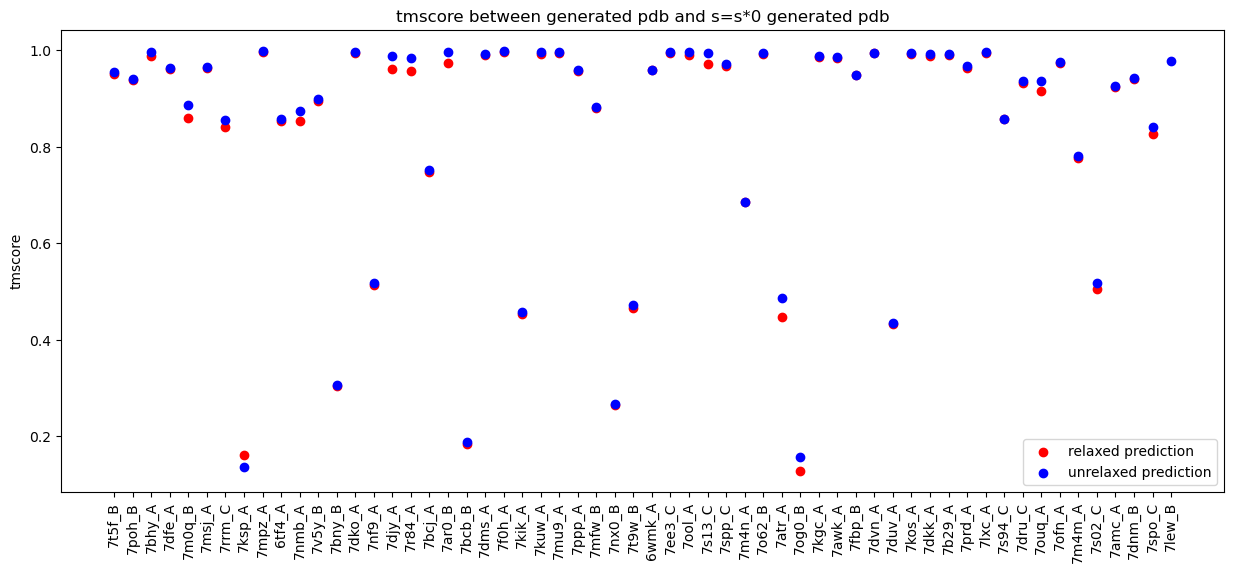

In [28]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]

#plt.scatter(list(validationrunsdict_relaxed.keys()), validationrunsdict_relaxed.values(),color='r',label='relaxed prediction')
plt.scatter(list(validationrunsdict_unrelax.keys()), validationrunsdict_unrelax.values(),color='b',label='unrelaxed prediction')
plt.legend()
plt.ylabel('tmscore')
plt.title('tmscore between generated pdb and s=s*0 generated pdb')
plt.xticks(rotation=90)
plt.show()

In [29]:
import os
import py3Dmol
import matplotlib.pyplot as plt
def plot_pdb(filename):
    print(filename)
    with open(filename) as ifile:
        system = "".join([x for x in ifile])
    view = py3Dmol.view(width=400, height=300)
    view.addModelsAsFrames(system)
    view.setStyle({'model': -1}, {"cartoon": {'color': 'spectrum'}})
    view.zoomTo()
    view.show()

In [33]:
# relaxed
correlations_r2 = {}
print(hmmfile_dict['6tf4_A'].keys())
for detail in hmmfile_dict['6tf4_A'].keys():
    x=[]
    y=[]
    for protein in validationrunsdict_unrelax:
        x.append(hmmfile_dict[protein][detail])
        y.append(validationrunsdict_unrelax[protein])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    correlations_r2[detail] = r_value**2
print('r^2 values computed from hmmfile and validation runs:\n')
sorted_keys=[]
for w in sorted(correlations_r2, key=correlations_r2.get, reverse=True):
    sorted_keys.append(w)
    print(correlations_r2[w], w)

print("\n M: \"The length of the model in consensus residues (match states)\"")
print("relent:\"Mean relative entropy per match state\"")
print("info:\"Mean information content per match state\"")
print("p relE:\"Mean positional relative entropy\"")
print("compKL:\"Kullback-Leibler divergence from the default background frequency distribution to the average composition of the profile’s consensus match states\"")

dict_keys(['nseq', 'eff_nseq', 'M', 'relent', 'info', 'prelE', 'compKL', 'FORWARD1', 'FORWARD2', 'FORWARD_delta', 'VITERBI1', 'VITERBI2', 'VITERBI_delta', 'amino_acid_len'])
r^2 values computed from hmmfile and validation runs:

0.2996880411941704 amino_acid_len
0.230170516179512 M
0.18504500700533663 FORWARD1
0.1847144301293159 FORWARD_delta
0.14258524854016477 FORWARD2
0.14258524854016477 VITERBI2
0.08156668402281086 VITERBI1
0.08113473795825299 VITERBI_delta
0.020235474626259395 eff_nseq
0.0065349775070811305 compKL
0.001257754207542272 prelE
0.0010488345781019205 relent
0.0007286066567311959 info
7.359460472171907e-08 nseq

 M: "The length of the model in consensus residues (match states)"
relent:"Mean relative entropy per match state"
info:"Mean information content per match state"
p relE:"Mean positional relative entropy"
compKL:"Kullback-Leibler divergence from the default background frequency distribution to the average composition of the profile’s consensus match states"


7ksp_A 23 0.1616
7bny_B 153 0.3049
7bcb_B 19 0.1836
7nx0_B 80 0.2656
7og0_B 18 0.1284


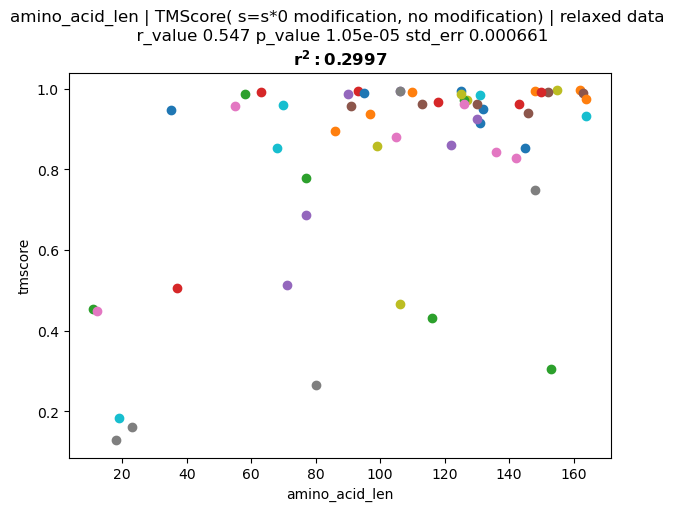

7ksp_A 230.0 0.1616
7bny_B 142.0 0.3049
7bcb_B 97.0 0.1836
7nx0_B 322.0 0.2656
7og0_B 513.0 0.1284


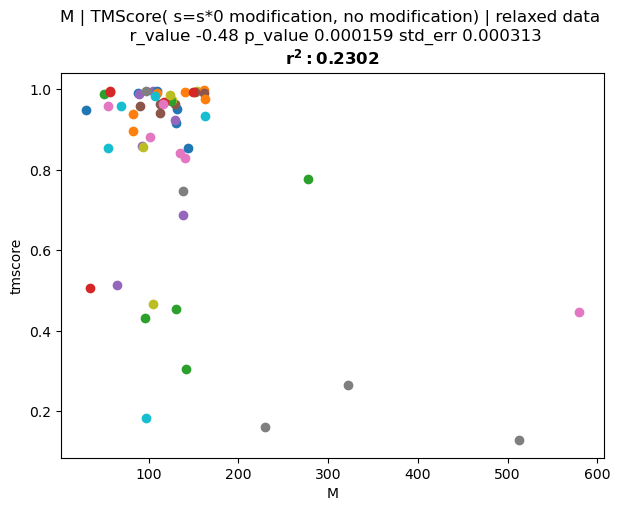

7ksp_A -4.9568 0.1616
7bny_B -4.5192 0.3049
7bcb_B -4.2786 0.1836
7nx0_B -5.227 0.2656
7og0_B -6.1522 0.1284


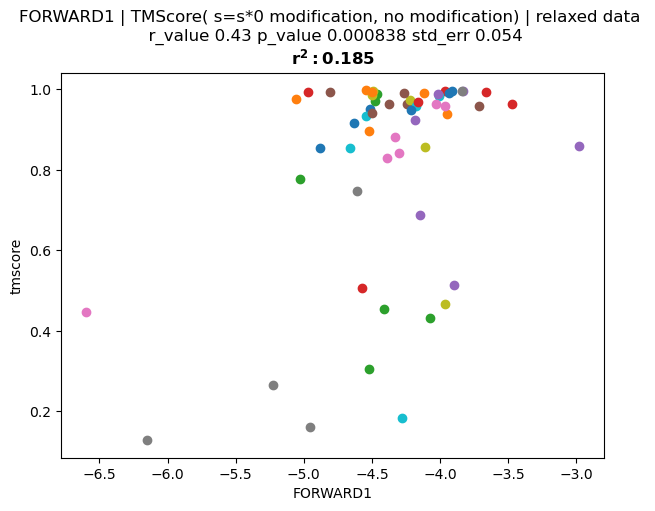

7ksp_A 5.66056 0.1616
7bny_B 5.22948 0.3049
7bcb_B 4.9969 0.1836
7nx0_B 5.92773 0.2656
7og0_B 6.85011 0.1284


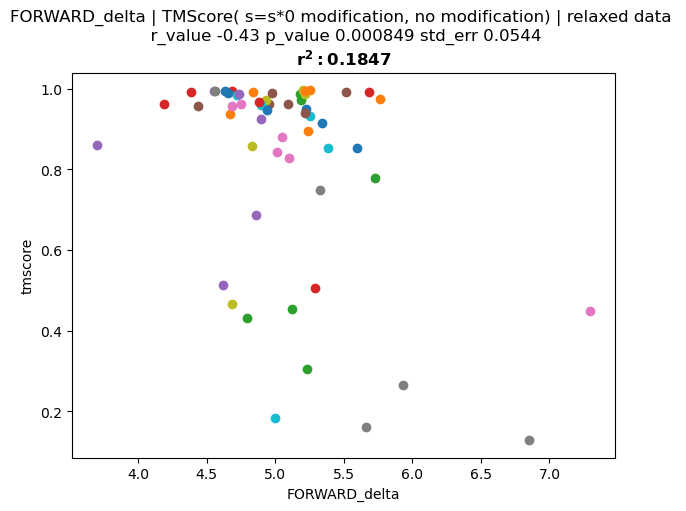

7ksp_A 0.70376 0.1616
7bny_B 0.71028 0.3049
7bcb_B 0.7183 0.1836
7nx0_B 0.70073 0.2656
7og0_B 0.69791 0.1284


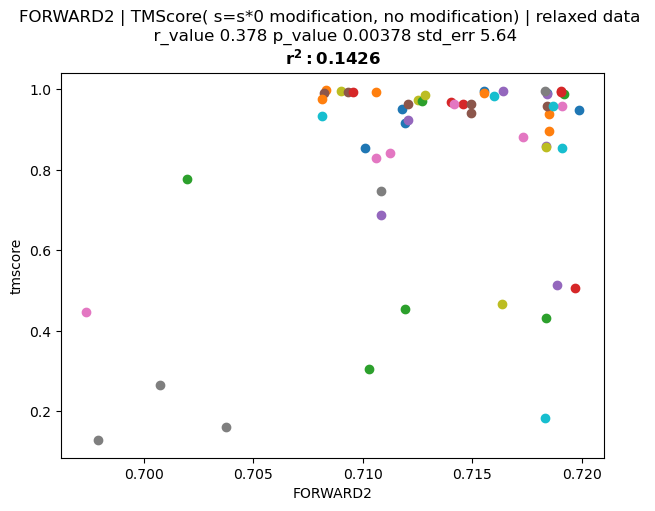

7ksp_A 0.70376 0.1616
7bny_B 0.71028 0.3049
7bcb_B 0.7183 0.1836
7nx0_B 0.70073 0.2656
7og0_B 0.69791 0.1284


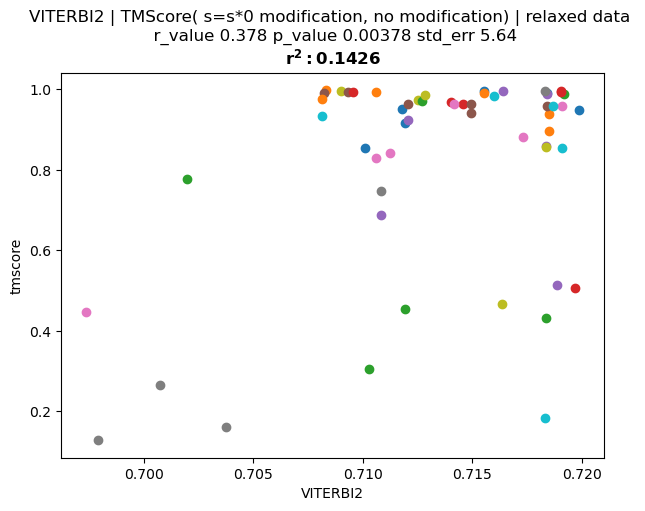

7ksp_A -11.6629 0.1616
7bny_B -10.8569 0.3049
7bcb_B -9.9909 0.1836
7nx0_B -12.2566 0.2656
7og0_B -12.6672 0.1284


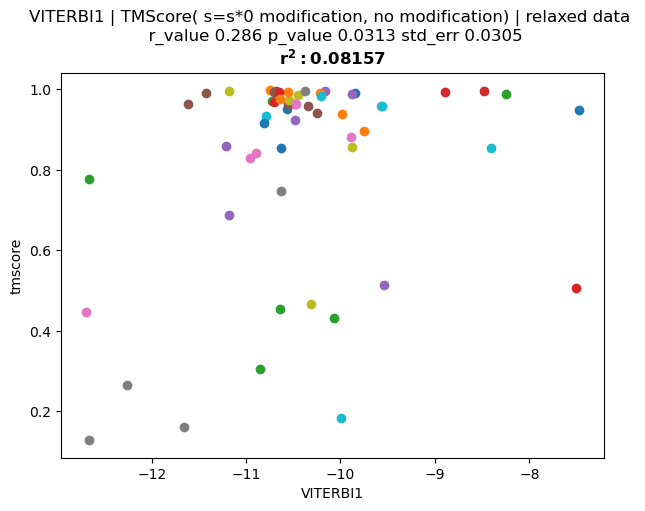

7ksp_A 12.366660000000001 0.1616
7bny_B 11.56718 0.3049
7bcb_B 10.7092 0.1836
7nx0_B 12.95733 0.2656
7og0_B 13.36511 0.1284


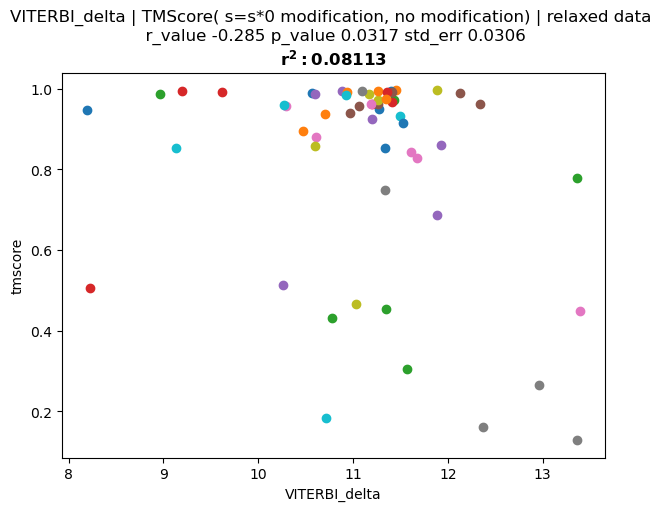

7ksp_A 3.21 0.1616
7bny_B 0.76 0.3049
7bcb_B 4.14 0.1836
7nx0_B 7.41 0.2656
7og0_B 8.37 0.1284


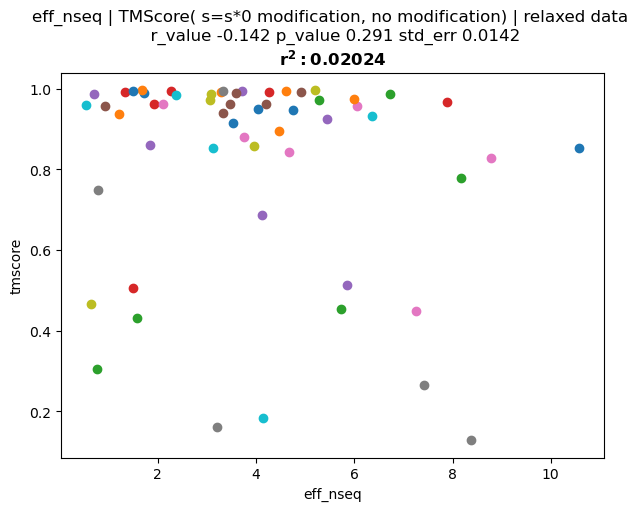

7ksp_A 0.04 0.1616
7bny_B 0.02 0.3049
7bcb_B 0.05 0.1836
7nx0_B 0.06 0.2656
7og0_B 0.02 0.1284


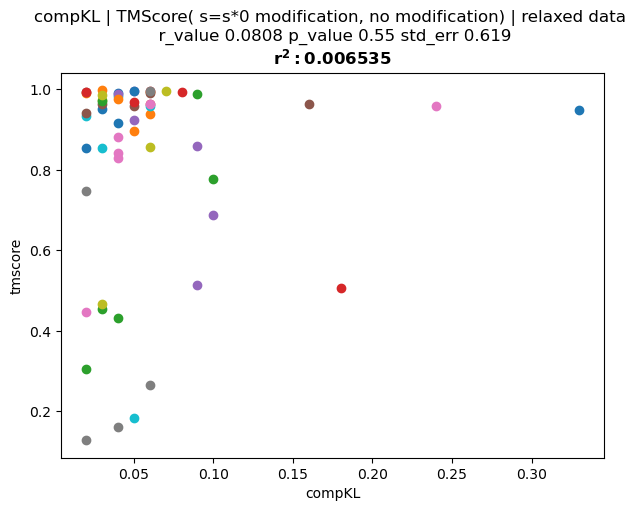

7ksp_A 0.52 0.1616
7bny_B 0.53 0.3049
7bcb_B 0.55 0.1836
7nx0_B 0.52 0.2656
7og0_B 0.52 0.1284


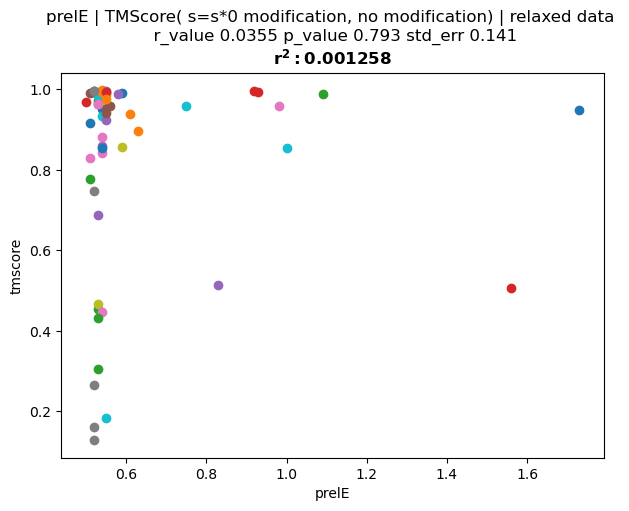

7ksp_A 0.59 0.1616
7bny_B 0.59 0.3049
7bcb_B 0.59 0.1836
7nx0_B 0.59 0.2656
7og0_B 0.59 0.1284


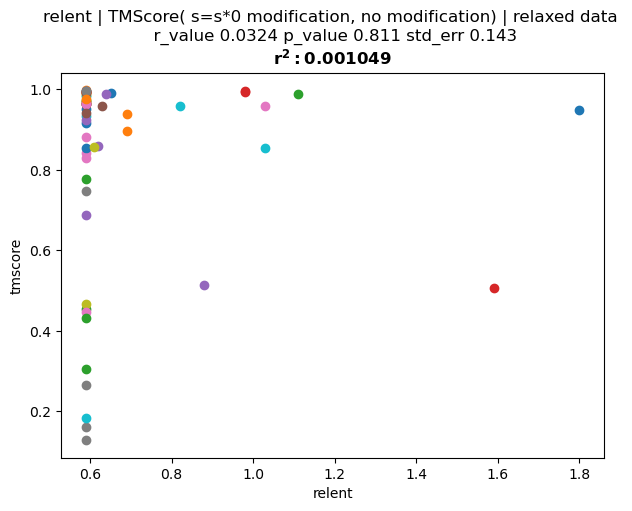

7ksp_A 0.55 0.1616
7bny_B 0.55 0.3049
7bcb_B 0.6 0.1836
7nx0_B 0.59 0.2656
7og0_B 0.57 0.1284


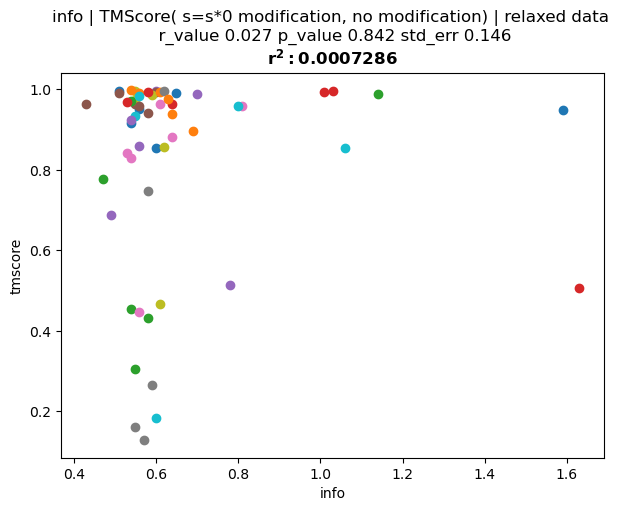

7ksp_A 742.0 0.1616
7bny_B 12.0 0.3049
7bcb_B 186.0 0.1836
7nx0_B 1512.0 0.2656
7og0_B 10000.0 0.1284


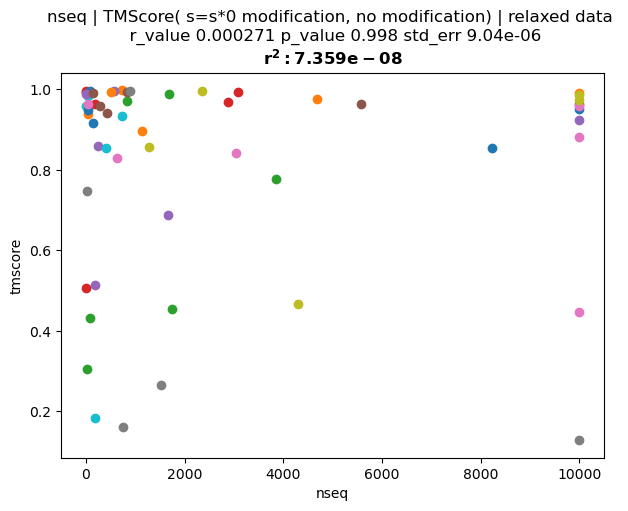

In [34]:
plt.rcParams['figure.figsize'] = [7, 5]
def plt_hmm_dict(detail):
    x=[]
    y=[]
    for pdb in validationrunsdict_unrelax:
        plt.scatter(hmmfile_dict[pdb][detail],validationrunsdict_unrelax[pdb])
        x.append(hmmfile_dict[pdb][detail])
        y.append(validationrunsdict_unrelax[pdb])
        if validationrunsdict_unrelax[pdb] < 0.4:
            print(pdb,hmmfile_dict[pdb][detail], validationrunsdict_unrelax[pdb])
        #print(pdb,hmmfile_dict[pdb],validationrunsdict_relaxed[pdb][0])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    plt.title('{} | TMScore( s=s*0 modification, no modification) | relaxed data \n  r_value {:.3} p_value {:.3} std_err {:.3} \n'.format(detail,r_value,p_value,std_err)
     + r"$\bf{r^2: " + "{:.4}".format(r_value**2) + "}$")
    plt.xlabel(detail)
    plt.ylabel('tmscore')
    #plt.xscale("log")
    plt.show()

for detail in sorted_keys:
    plt_hmm_dict(detail)

In [36]:
# un relaxed
correlations_r2 = {}
print(hmmfile_dict['6tf4_A'].keys())
for detail in hmmfile_dict['6tf4_A'].keys():
    x=[]
    y=[]
    for protein in validationrunsdict_unrelax:
        x.append(hmmfile_dict[protein][detail])
        y.append(validationrunsdict_unrelax[protein])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    correlations_r2[detail] = r_value**2
print('r^2 values computed from hmmfile and validation runs:\n')
sorted_keys=[]
for w in sorted(correlations_r2, key=correlations_r2.get, reverse=True):
    sorted_keys.append(w)
    print(correlations_r2[w], w)

print("\n M: \"The length of the model in consensus residues (match states)\"")
print("relent:\"Mean relative entropy per match state\"")
print("info:\"Mean information content per match state\"")
print("p relE:\"Mean positional relative entropy\"")
print("compKL:\"Kullback-Leibler divergence from the default background frequency distribution to the average composition of the profile’s consensus match states\"")

#
'''
plt.rcParams['figure.figsize'] = [7, 5]
def plt_hmm_dict(detail):
    x=[]
    y=[]
    for pdb in validationrunsdict_unrelax:
        plt.scatter(hmmfile_dict[pdb][detail],validationrunsdict_unrelax[pdb])
        x.append(hmmfile_dict[pdb][detail])
        y.append(validationrunsdict_unrelax[pdb])
        if validationrunsdict_unrelax[pdb] < 0.4:
            print(pdb,hmmfile_dict[pdb][detail], validationrunsdict_unrelax[pdb])
        #print(pdb,hmmfile_dict[pdb],validationrunsdict_relaxed[pdb][0])
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    plt.title('{} | TMScore( s=s*0 modification, no modification) | relaxed data \n  r_value {:.3} p_value {:.3} std_err {:.3} \n'.format(detail,r_value,p_value,std_err)
     + r"$\bf{r^2: " + "{:.4}".format(r_value**2) + "}$")
    plt.xlabel(detail)
    plt.ylabel('tmscore')
    #plt.xscale("log")
    plt.show()

for detail in sorted_keys:
    plt_hmm_dict(detail)
'''

dict_keys(['nseq', 'eff_nseq', 'M', 'relent', 'info', 'prelE', 'compKL', 'FORWARD1', 'FORWARD2', 'FORWARD_delta', 'VITERBI1', 'VITERBI2', 'VITERBI_delta', 'amino_acid_len'])
r^2 values computed from hmmfile and validation runs:

0.2990187733802342 amino_acid_len
0.22088374856855472 M
0.17474184143156435 FORWARD1
0.17430922054724626 FORWARD_delta
0.14194264906123333 FORWARD2
0.14194264906123333 VITERBI2
0.08254160623112777 VITERBI1
0.08212945640223435 VITERBI_delta
0.019035825898280356 eff_nseq
0.012280275081829202 compKL
0.004789073333273355 prelE
0.00441722730682005 relent
0.003631825911694839 info
0.00012561020267497138 nseq

 M: "The length of the model in consensus residues (match states)"
relent:"Mean relative entropy per match state"
info:"Mean information content per match state"
p relE:"Mean positional relative entropy"
compKL:"Kullback-Leibler divergence from the default background frequency distribution to the average composition of the profile’s consensus match states"


'\nplt.rcParams[\'figure.figsize\'] = [7, 5]\ndef plt_hmm_dict(detail):\n    x=[]\n    y=[]\n    for pdb in validationrunsdict_unrelax:\n        plt.scatter(hmmfile_dict[pdb][detail],validationrunsdict_unrelax[pdb])\n        x.append(hmmfile_dict[pdb][detail])\n        y.append(validationrunsdict_unrelax[pdb])\n        if validationrunsdict_unrelax[pdb] < 0.4:\n            print(pdb,hmmfile_dict[pdb][detail], validationrunsdict_unrelax[pdb])\n        #print(pdb,hmmfile_dict[pdb],validationrunsdict_relaxed[pdb][0])\n    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)\n    plt.title(\'{} | TMScore( s=s*0 modification, no modification) | relaxed data \n  r_value {:.3} p_value {:.3} std_err {:.3} \n\'.format(detail,r_value,p_value,std_err)\n     + r"$\x08f{r^2: " + "{:.4}".format(r_value**2) + "}$")\n    plt.xlabel(detail)\n    plt.ylabel(\'tmscore\')\n    #plt.xscale("log")\n    plt.show()\n\nfor detail in sorted_keys:\n    plt_hmm_dict(detail)\n'

In [14]:
vdatanames = [
'6tf4_A', '6wmk_A', '6wqc_A', '6xqj_A', '6z01_A', '7ab3_E', '7amc_A', '7ar0_B', '7atr_A', '7au7_A', '7awk_A', '7b0d_A', '7b1k_B', '7b1w_F', '7b26_C', '7b28_F', '7b29_A', '7b2a_A', '7b2o_A', '7b3a_A', '7b4q_A', '7b7t_A', '7bbz_A', '7bcb_B', '7bcj_A', '7bcz_A', '7bew_A', '7bhy_A', '7bny_B', '7cjs_B', '7da9_A', '7dah_E', '7dck_A', '7dcm_A', '7dfe_A', '7djy_A', '7dk9_A', '7dkk_A', '7dko_A', '7dmf_A', '7dms_A', '7dnm_B', '7dnu_A', '7don_B', '7dq9_A', '7dqg_A', '7dru_C', '7dsu_B', '7dtp_A', '7dut_A', '7duv_A', '7dvn_A', '7e0m_A', '7e2v_A', '7e37_A', '7e3z_A', '7ee3_C', '7eea_A', '7ef6_A', '7eft_B', '7eqx_A', '7eqx_C', '7esx_A', '7et8_A', '7ezg_A', '7f0h_A', '7f17_B', '7f6e_B', '7f8a_A', '7fbh_A', '7fbp_B', '7fe3_A', '7fh3_A', '7fip_A', '7kdx_B', '7kgc_A', '7kik_A', '7kiu_A', '7kos_A', '7kqv_D', '7ksp_A', '7kua_A', '7kuw_A', '7kzh_A', '7l19_C', '7l6j_A', '7l6y_A', '7lbu_A', '7lc5_A', '7lew_B', '7ljh_A', '7lnu_B', '7ls0_B', '7lvz_D', '7lxc_A', '7m0q_B', '7m4m_A', '7m4n_A', '7mfi_A', '7mfw_B', '7mpz_A', '7mqy_A', '7mrk_D', '7mro_A', '7mrq_A', '7mrs_B', '7msj_A', '7mu9_A', '7ndr_A', '7nf9_A', '7nl4_A', '7nmb_A', '7nwz_D', '7nx0_B', '7nx0_E', '7ny6_A', '7o49_F', '7o62_B', '7obm_A', '7ofn_A', '7og0_B', '7ool_A', '7ouq_A', '7p1b_C', '7p1v_A', '7p3b_B', '7p3t_B', '7p82_C', '7pbk_A', '7pkx_A', '7plb_B', '7plq_B', '7poh_B', '7ppp_A', '7pq7_A', '7pqf_A', '7prd_A', '7q03_A', '7q1b_A', '7q47_A', '7r84_A', '7rbw_A', '7rds_A', '7rdt_A', '7re4_A', '7re6_A', '7rg7_A', '7rrm_C', '7rwk_A', '7s02_C', '7s13_C', '7s13_L', '7s6g_A', '7s94_C', '7sf6_A', '7sh3_A', '7siq_A', '7sir_A', '7spo_C', '7spp_C', '7swh_A', '7swk_B', '7sy9_A', '7t24_A', '7t5f_B', '7t71_A', '7t8o_B', '7t9w_B', '7tav_B', '7tbs_A', '7tcb_B', '7v1v_A', '7v5y_B', '7v6p_A', '7vdy_A', '7vmu_A', '7vnb_A', '7vpf_A', '7w83_A', '7wbr_A' ]

with open('fasta_dir/cameovalidationdata.fasta') as f:
    fastafile = f.readlines()

def rename(original):
    new = [x for x in vdatanames if x.startswith(original.lower())]
    return new[0]
#print(rename('7T8O'))

In [24]:
'''
file = open("fasta_dir/vdata_modified.fasta", "w")
for line in fastafile:
    if line.startswith('>'):
        file.write('>' + rename(line[1:5]) + ' |' + line)
        #print(line[1:5] + 'to' + rename(line[1:5]))
        #print('>' + rename(line[1:5]) + ' |' + line)
    else:
        #print(line)
        file.write(line)

file.close()
'''

In [25]:
def savefastafile(data,name):
    file = open('fasta_dir/'+name+'.fasta','w')
    file.write(data)
    file.close()

In [30]:
with open('old_fastas/vdata_modified.fasta') as f:
    fastafile = f.readlines()

In [42]:
for line in fastafile:
    if line.startswith('>'):
        file = open('fasta_dir/'+line[1:7]+'.fasta','w')
        file.write(line[0:8]+ ' |' + line[16:])
    else:
        file.write(line)
        file.close()

6t1z and 4ja4 showed no change when s=s*0
run failed when z=z*0: "Particle coordinate is nan"
6t1z no modifications has a longer tail and new connection that the target (or AF2 prediction) doesn't have. Likely due to the shallow MSA


In [4]:

def filenames():
    for run_pdb in os.listdir('output'):
        if run_pdb[-1] == "b": print(run_pdb)
filenames()

1urpxray_downloaded_0_z_xrayscattering.pdb
2DRI_noise_17.0_z_prediction.pdb
2DRI_noise_9.0_z_prediction.pdb
1ba2xray_downloaded_0_z_xrayscattering.pdb
2drixray_downloaded_0_z_xrayscattering.pdb
2DRI_noise_1.0_z_prediction.pdb
2DRI_noise_20.0_z_prediction.pdb
2DRI_noise_3.0_z_prediction.pdb
2DRI_none_0.0_z_prediction.pdb
2DRI_noise_10.0_z_prediction.pdb
2DRI_noise_13.0_z_prediction.pdb
2DRI_noise_6.0_z_prediction.pdb
2DRI_noise_15.0_z_prediction.pdb


In [6]:
def tmscore_dict(directory,target_pdbs):
    dict = {}
    for run_pdb in os.listdir('output'):
        if run_pdb[-1] == "b":
            target_pdb = ''
            for possible_target_pdb in target_pdbs:
                if run_pdb[0:3] == possible_target_pdb[0:3]:
                    target_pdb = possible_target_pdb
            parsed_name = run_pdb.split('_')
            dict[run_pdb] = {}
            dict[run_pdb]['protien'] = parsed_name[0]
            dict[run_pdb]['mode'] = parsed_name[1]
            dict[run_pdb]['value'] = float(parsed_name[2])
            dict[run_pdb]['rep'] = parsed_name[3]
            dict[run_pdb]['tmscore'] = tmscore(directory + target_pdb, directory + run_pdb)
    return dict

#d = tmscore_dict('output/',['7MZZ_none_1.0_s_prediction.pdb','5D3W_none_1.0_s_prediction.pdb','4O75_none_1.0_s_prediction.pdb','1DGN_none_1.0_s_prediction.pdb'])


In [7]:
def plot_tmruns(dict,protien,mode,rep,color,marker,label=''):
    legend_marker = True
    for run_pdb in dict:
        if dict[run_pdb]['protien'] == protien and dict[run_pdb]['mode'] == mode and dict[run_pdb]['rep'] == rep:
            plt.scatter(dict[run_pdb]['value'],dict[run_pdb]['tmscore'],color=color,marker=marker)#,label=label if legend_marker else '')


In [8]:
def tmscore_dict_mult_conf(directory,target_pdbs):
    dict = {}
    for run_pdb in os.listdir(directory):
        if run_pdb[-1] == "b":
            parsed_name = run_pdb.split('_')
            dict[run_pdb] = {}
            dict[run_pdb]['protien'] = parsed_name[0]
            dict[run_pdb]['mode'] = parsed_name[1]
            dict[run_pdb]['value'] = float(parsed_name[2])
            dict[run_pdb]['rep'] = parsed_name[3]
            dict[run_pdb]['tmscore'] = {}
            for target_pdb in target_pdbs:
                dict[run_pdb]['tmscore'][target_pdb.split('_')[0]] = tmscore(directory + target_pdb, directory + run_pdb)
    return dict


In [79]:
d_mult_conf_xyle = tmscore_dict_mult_conf('old/output-xyle/',['4JA3_none_1.0_s_prediction.pdb', '4JA4_none_1.0_s_prediction.pdb', '6N3I_none_1.0_s_prediction.pdb'])

In [80]:
d_1ake_4ake_run = tmscore_dict_mult_conf('old/output-1ake/',['1AKExray_downloaded_0_z_xrayscattering.pdb', '4AKExray_downloaded_0_z_xrayscattering.pdb','1AKE_none_1.0_s_prediction.pdb'])

In [9]:
d_2dri = tmscore_dict_mult_conf('output/',['2drixray_downloaded_0_z_xrayscattering.pdb', '1ba2xray_downloaded_0_z_xrayscattering.pdb','1urpxray_downloaded_0_z_xrayscattering.pdb','2DRI_none_0.0_z_prediction.pdb'])

In [10]:
def plot_tmruns_mult_conf(dict,run_protien,target_protiens):
    '''
    This plots all the protiens and their many tmscores in the dictionary. Since the dict is made from the output file, all pdbs in 
    the output file will be here. different runs need to be separated. 
    Assume: mode = noise. representation = z.
    '''
    colors = ['blue','red','green','black']
    markers = ['>','+','<','*']
    for i,_ in enumerate(target_protiens): # *protien* is the target protien the tmscore is against.
        first_label = True
        label = 'against: ' + target_protiens[i]
        for run_pdb in dict:
            if dict[run_pdb]['protien'] == run_protien:
                plt.scatter(dict[run_pdb]['value'],dict[run_pdb]['tmscore'][target_protiens[i]],color=colors[i],marker=markers[i], label=label if first_label else '')
                first_label = False
    plt.legend()
    plt.title(run_protien + ' sequence used with noise applied to pair rep')
    plt.xlabel('noising value')
    plt.ylabel('tmscore')
    


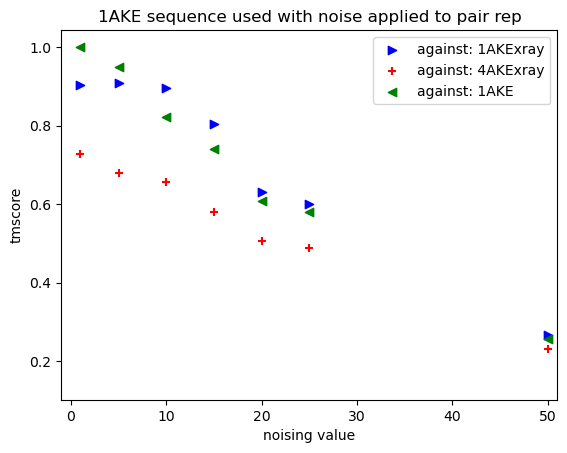

In [83]:
plot_tmruns_mult_conf(d_1ake_4ake_run,'1AKE',['1AKExray','4AKExray','1AKE'])
plt.xlim(-1,51)
plt.show()


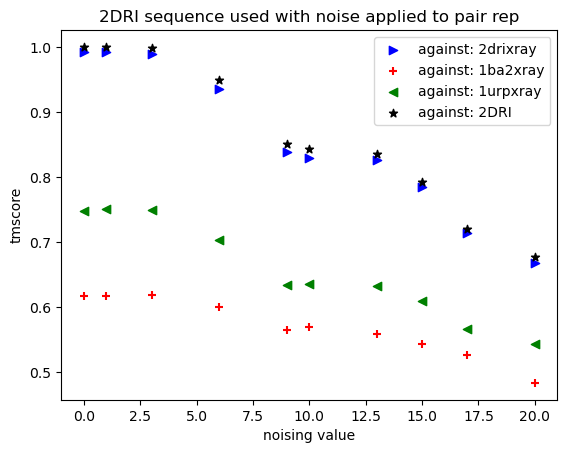

In [11]:
plot_tmruns_mult_conf(d_2dri,'2DRI',['2drixray','1ba2xray','1urpxray','2DRI'])
#plt.xlim(-1,51)
plt.show()

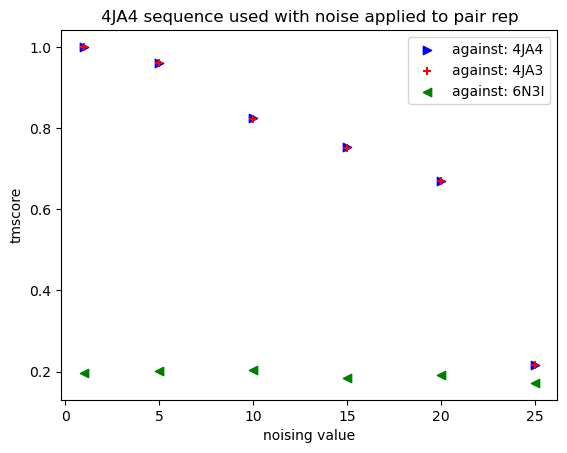

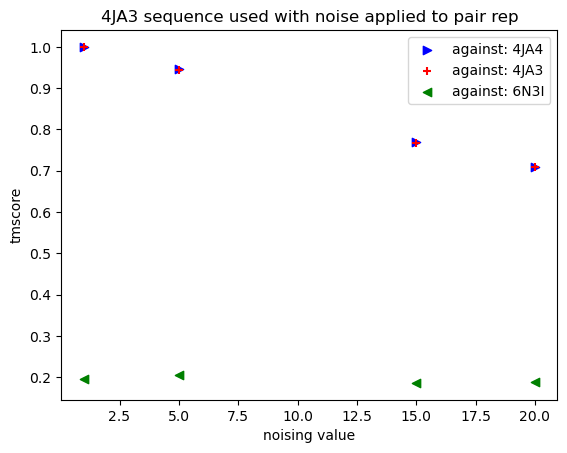

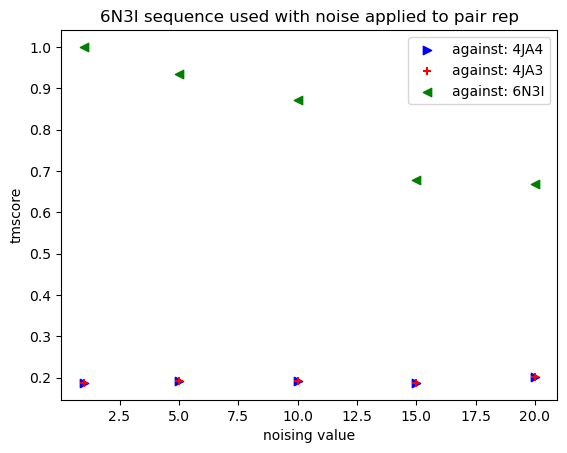

In [63]:
plot_tmruns_mult_conf(d_mult_conf_xyle,'4JA4',['4JA4','4JA3','6N3I'])
plt.show()
plot_tmruns_mult_conf(d_mult_conf_xyle,'4JA3',['4JA4','4JA3','6N3I'])
plt.show()
plot_tmruns_mult_conf(d_mult_conf_xyle,'6N3I',['4JA4','4JA3','6N3I'])
plt.show()

In [ ]:
# 1ake/4ake study
# Different conformations, same sequence
# - compare run to xray data, not unmodified-computed

In [165]:

#print(tmscore(a,b))
#plot_pdb(a)
#plot_pdb(b)
t2 = 'output/4JA3_none_1.0_s_prediction.pdb'
a10 = 'output/4JA4_noise_10.0_z_prediction.pdb'
t1 = 'output/4JA4_none_1.0_s_prediction.pdb'
t3 = 'output/6N3I_none_1.0_s_prediction.pdb'
a15 = 'output/4JA4_noise_15.0_z_prediction.pdb'
a5 = 'output/4JA4_noise_5.0_z_prediction.pdb'

print('4ja4 4ja3',tmscore(t1,t2))
print('4ja4 6n3i',tmscore(t1,t3))

print('4ja4 4ja4*noise(5)',tmscore(t1,a5))
print('4ja4 4ja4*noise(10)',tmscore(t1,a10))
print('4ja4 4ja4*noise(15)',tmscore(t1,a15))

print('4ja3 4ja4*noise(5)',tmscore(t2,a5))
print('4ja3 4ja4*noise(10)',tmscore(t2,a10))
print('4ja3 4ja4*noise(15)',tmscore(t2,a15))

print('6n3i 4ja4*noise(5)',tmscore(t3,a5))
print('6n3i 4ja4*noise(10)',tmscore(t3,a10))
print('6n3i 4ja4*noise(15)',tmscore(t3,a15))

plot_pdb(t3)

4ja4 4ja3 0.9989
4ja4 6n3i 0.1884
4ja4 4ja4*noise(5) 0.961
4ja4 4ja4*noise(10) 0.825
4ja4 4ja4*noise(15) 0.7528
4ja3 4ja4*noise(5) 0.9599
4ja3 4ja4*noise(10) 0.822
4ja3 4ja4*noise(15) 0.7505
6n3i 4ja4*noise(5) 0.2026
6n3i 4ja4*noise(10) 0.2033
6n3i 4ja4*noise(15) 0.1833
output/6N3I_none_1.0_s_prediction.pdb


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [151]:
def plot_mult_conf(d,target1,target2):
    pass
plot_mult_conf()

TypeError: plot_mult_conf() missing 3 required positional arguments: 'd', 'target1', and 'target2'

In [142]:
def bulk_plot_doe(d,m,t):
    plt.scatter(0,0, marker=".", color = 'blue', label='(s) single rep')
    plt.scatter(0,0, marker=".", color = 'red', label='(z) pair rep')
    plt.scatter(0,0, marker=".", color = 'green', label='(m) msa rep')
    plt.scatter(0,0, marker=".", color = 'black', label='(sz)')
    plt.scatter(0,0, marker=".", color = 'orange', label='(sm)')
    plt.scatter(0,0, marker=".", color = 'brown', label='(zm)')
    for p,marker in zip(['7MZZ','5D3W','4O75','1DGN'],['>','*','+','<']):
        print(marker,p)
        plot_tmruns(d,p,m,'s','blue',marker)
        plot_tmruns(d,p,m,'m','green',marker)
        plot_tmruns(d,p,m,'z','red',marker)
        #plot_tmruns(d,p,m,'sz','black',marker)
        #plot_tmruns(d,p,m,'sm','orange',marker)
        #plot_tmruns(d,p,m,'zm','brown',marker)
    plt.legend()
    plt.xscale('log')
    plt.xlabel('value')
    plt.ylabel('tmscore')
    plt.title(t)
    plt.show()
if False:
    bulk_plot_doe(d,'mult','multiplying representation ')
    bulk_plot_doe(d,'noise','noising representation ')
    bulk_plot_doe(d,'zero','zeroing representation ')